# Anime recommendation system

Greetings anime enthusiasts! As a relatively new fan of anime, I find myself overwhelmed with the sheer number of anime titles available to watch. With limited time on my hands, I need a way to narrow down my options and discover the best anime that align with my interests. To solve this problem, I embarked on a project to build an anime recommendation system.

In this notebook, I'll take you on my journey of creating a personalized anime recommendation system using Kaggle's anime recommendation dataset. Through various algorithms and techniques, I'll demonstrate how my model can suggest anime titles based on my viewing history and preferences.

So, whether you're a seasoned anime fan trying to catch up on the latest titles, or a newbie like me trying to discover the best anime out there, join me in exploring the exciting world of anime recommendation systems.

## Table of Contents

* [Introduction](#section-one)
    - [Loading of dataset](#subsection-one)
* [Exploratory Data Analysis](#section-two)
    - [Exploration of data](#subsection-two)
    - [Analysis of data](#subsection-three)
* [Recommendation System](#section-three)
    - [Content Based Filtering ](#subsection-four)
    - [Collaborative Filtering ](#subsection-five)
* [Conclusion](#section-four)

<a class="anchor" id="section-one"></a>
## Introduction

The anime recommendations database is a comprehensive dataset that contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.

Anime.csv

**anime_id** - myanimelist.net's unique id identifying an anime.\
**name** - full name of anime.\
**genre** - comma separated list of genres for this anime.\
**type** - movie, TV, OVA, etc.\
**episodes** - how many episodes in this show. (1 if movie).\
**rating** - average rating out of 10 for this anime.\
**members** - number of community members that are in this anime's "group".

Rating.csv

**user_id** - non identifiable randomly generated user id.\
**anime_id** - the anime that this user has rated.\
**rating** - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).


<a class="anchor" id="subsection-one"></a>
### Load data and importing libraries

In [1]:
# Data analysis
import numpy as np 
import pandas as pd 

# Visualization of data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Loading anime.csv and rating.csv
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

<a class="anchor" id="section-two"></a>
## Exploratory Data Analysis (EDA)

<a class="anchor" id="subsection-two"></a>
### Exploration of data
Let's first explore the anime dataset

In [3]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [5]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [6]:
anime.describe(include=['O'])

,name,genre,type,episodes
count,12294,12232,12269,12294
unique,12292,3264,6,187
top,Shi Wan Ge Leng Xiaohua,Hentai,TV,1
freq,2,823,3787,5677


It is noted that **genre**, **type**, and **rating** has null values.\
Now lets take a look at the rating dataset

In [7]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [8]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [9]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


Since there is no proper way to impute missing values of genre, type and rating. We will drop the rows of null values in the anime dataset

In [10]:
anime.dropna(inplace=True)
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


<a class="anchor" id="subsection-three"></a>
### Analysis of data

Now let us take a look at each column and see what we can find out about each anime

#### Top 10 anime of all time

Upon researching, myanimelist ranks their animes based on weighted score rather than the actual rating which can be calculated as follows:

$$ Weighted Score = \frac {S*v} {v+m} + \frac {Cm} {v+m} $$

S = Average score for the anime\
v = Number of valid users giving a score for the anime
m = Minimum number of scored users required to get a calculated score
C = The mean across the entire anime database

Thus we can't use the rating to rank the anime. Luckily, the anime dataset came in the weighted score ranking and we can just use it to plot the top 10 animes of all time.

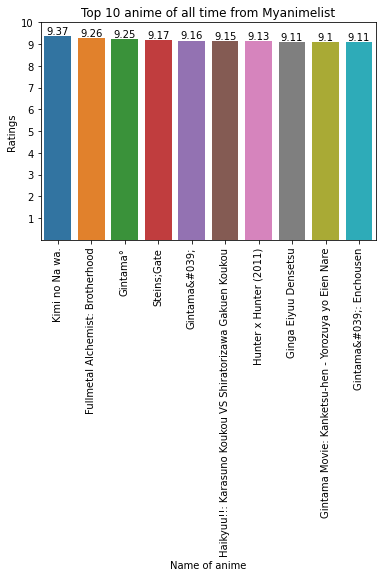

In [11]:
# Get top 10 animes
dfplot = anime.head(10)

# Barplot with name with y as rating
sns.barplot(data=dfplot,x='name',y='rating')

# Set the plot 
plt.xticks(rotation=90)
plt.title('Top 10 anime of all time from Myanimelist')
plt.yticks(np.arange(1,11))
plt.xlabel('Name of anime')
plt.ylabel('Ratings')

# Add labels to the bars
for index, row in dfplot.iterrows():
    plt.text(index, row['rating'], str(row['rating']), ha='center', va='bottom')


plt.show()

#### Genre distribution

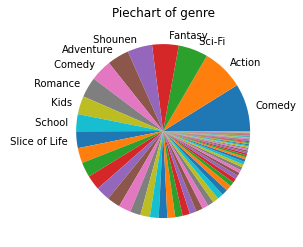

In [12]:
anime_df = anime.copy()

# Split the comma-separated genres into a list of strings and assign to a new column
anime_df['genres_list'] = anime_df['genre'].str.split(',')

# Explode the list of genres into separate rows, duplicating the other columns as necessary
anime_df = anime_df.explode('genres_list')
genre = anime_df.value_counts('genres_list')

# Get top 10 genres 
new_labels = ['']*len(genre)
new_labels[:11] = genre.index[:11]
new_labels

# Plot piechart
plt.pie(genre,labels=new_labels)
plt.title('Piechart of genre')
plt.show()

#### Type category distribution

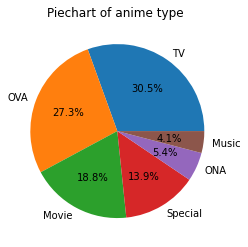

In [13]:
# Count the number of unique type
types = anime.type.value_counts()

# Plot piechart of types
plt.pie(types,labels=types.index,autopct='%.1f%%')
plt.title('Piechart of anime type ')
plt.show()

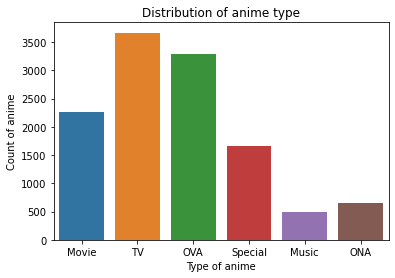

In [14]:
# Plot the count of type
sns.countplot(data=anime,x='type')

# Set the plot
plt.title('Distribution of anime type')
plt.xlabel('Type of anime')
plt.ylabel('Count of anime')
plt.show()

#### Episodes

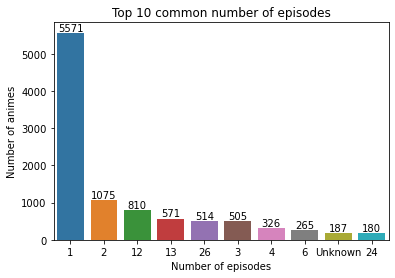

In [15]:
# Get top 10 number of episodes
ep = anime.episodes.value_counts().head(10)

# Barplot the number of episodes with counts
sns.barplot(x=ep.index,y=ep.values)

# Set the plot
plt.title('Top 10 common number of episodes')
plt.xlabel('Number of episodes')
plt.ylabel('Number of animes')

# Add the label on the barchart
for i,v in enumerate(ep):
    plt.text(i,v,str(v),ha='center',va='bottom')
    
plt.show()

#### Rating distribution

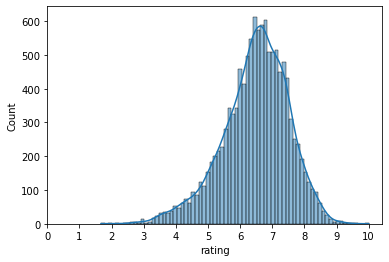

In [16]:
# Plot histogram of ratings for anime
sns.histplot(data=anime,x='rating',kde=True)
plt.xticks(np.arange(0,11))
plt.show()

#### Top 10 anime fanbase based on members

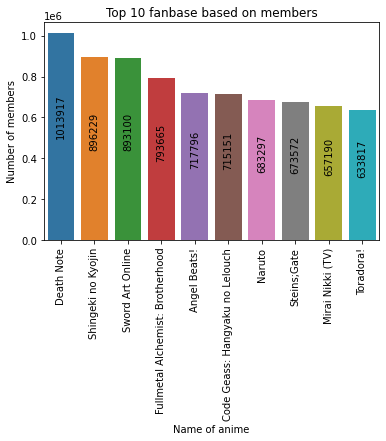

In [17]:
# Sort anime by members and get the top 10
dfplot = anime.sort_values('members',ascending=False).head(10)
dfplot.reset_index(inplace=True)

# Barplot dfplot with name and members
sns.barplot(data=dfplot, x='name', y='members')

# Set the plot
plt.xticks(rotation=90)
plt.title('Top 10 fanbase based on members')
plt.xlabel('Name of anime')
plt.ylabel('Number of members')

# Plot the number of members on the barchart
for index, value in dfplot.iterrows():
    plt.text(index,value['members']/2,str(value['members']),ha="center",rotation=90)

plt.show()

#### Rating csv

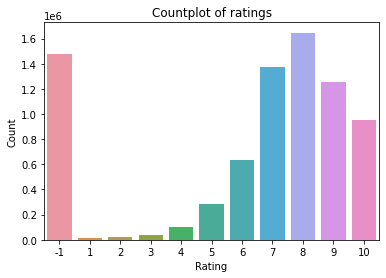

In [18]:
# Count plot of ratings in rating.csv
sns.countplot(data=rating,x='rating')

# Set the plot
plt.title('Countplot of ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

<a class="anchor" id="section-three"></a>
## Recommendation system

<a class="anchor" id="subsection-four"></a>

### Content-Based Filtering (CBF)

**Content-Based Filtering** is a type of recommendation system that uses the characteristics or features of items (in this case, anime) to recommend similar items to users. CBF works by first analyzing the content of each anime to extract features such as the anime's genre, studio, or rating. Then, it builds a model that can predict how likely a user is to enjoy an anime based on these features.

For the anime dataset, we can use CBF to recommend anime to users based on the genres of anime they have previously enjoyed. Specifically, we can use the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer to convert the list of genres for each anime into a feature matrix. TF-IDF is a statistical method that reflects the importance of each term (in our case, each genre) in a corpus of documents (in our case, the set of all anime). It accounts for the frequency of each term in each document (anime) as well as the frequency of each term across all documents (anime) to compute a weight that reflects the importance of each term in distinguishing one document (anime) from another.

Using the TF-IDF feature matrix, we can then use the cosine similarity metric to compute the similarity between each pair of anime based on their genre features. Finally, we can recommend anime to a user based on their previously watched anime and the anime that are most similar to those they have enjoyed.

Since I am only interested in watching TV series, I will remove those that are not in this category.

In [19]:
anime = anime.loc[anime['type']=='TV']
anime.reset_index(drop=True, inplace=True)

In [20]:
# Convert the "genre" column to a list of strings
anime['genre'] = anime['genre'].fillna('').apply(lambda x: x.split(','))

# Create a TF-IDF matrix from the "genre" column
tfidf = TfidfVectorizer(analyzer=lambda x: x)
tfidf_matrix = tfidf.fit_transform(anime['genre'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Define a function that takes an anime title as input and outputs the top 10 most similar anime titles
indices = pd.Series(anime.index, index=anime['name'])

def get_recommendations(title,num_recommendations=5):
    index = indices[title]

    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]

    anime_indices = [i[0] for i in sim_scores]
    return anime.loc[anime.index.isin(anime_indices)].head(num_recommendations)

#     return anime['name'].iloc[anime_indices]

# Example usage
get_recommendations('Sword Art Online',5)

,anime_id,name,genre,type,episodes,rating,members
230,17265,Log Horizon,"[Action, Adventure, Fantasy, Game, Magic, ...",TV,25,8.14,387100
281,29803,Overlord,"[Action, Adventure, Fantasy, Game, Magic, ...",TV,13,8.04,244268
614,23321,Log Horizon 2nd Season,"[Action, Adventure, Fantasy, Game, Magic, ...",TV,25,7.66,215817
675,21639,Yu☆Gi☆Oh! Arc-V,"[Action, Fantasy, Game, Shounen]",TV,Unknown,7.61,17571
1077,21881,Sword Art Online II,"[Action, Adventure, Fantasy, Game, Romance]",TV,24,7.35,537892


<a class="anchor" id="subsection-five"></a>

### User-Based Collaborative Filtering (UBCF)

**User-Based Collaborative Filtering** is a popular technique for building recommendation systems that suggest items to users based on their similarity to other users. The approach works by analyzing the past behavior of users and identifying those with similar preferences.

To determine the similarity between two users, UBCF typically uses a similarity metric such as cosine similarity or Pearson correlation coefficient. These metrics measure the similarity of users' preferences and can be used to determine the users who are most similar to each other.

Once UBCF identifies the similar users, it then recommends items to the target user that the similar users have enjoyed. For instance, if user A has similar preferences to user B, and user B enjoyed watching a particular movie, then UBCF may recommend that movie to user A. UBCF is based on the assumption that users who have enjoyed similar items in the past are likely to enjoy similar items in the future. As such, it is an effective approach for building personalized recommendation systems that provide relevant suggestions to each user.

In [21]:
# Filter the anime dataset to include only the most popular anime
anime_counts = rating.groupby('anime_id')['user_id'].count()
popular_anime_ids = anime_counts[anime_counts >= 1000].index
anime = anime[anime['anime_id'].isin(popular_anime_ids)]

# Filter the rating dataset to include only users who have rated at least 150 anime
user_counts = rating.groupby('user_id')['anime_id'].count()
active_user_ids = user_counts[user_counts >= 150].index
rating = rating[rating['user_id'].isin(active_user_ids)]


In [22]:
# Merge the anime and rating dataset
merged_df = anime.merge(rating, on='anime_id', how='left', suffixes=('_anime', '_user'))
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3005260 entries, 0 to 3005259
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   anime_id      int64  
 1   name          object 
 2   genre         object 
 3   type          object 
 4   episodes      object 
 5   rating_anime  float64
 6   members       int64  
 7   user_id       int64  
 8   rating_user   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 229.3+ MB


In [23]:
# Final data preprocessing by removing rating = -1 and not TV type
merged_df = merged_df.loc[merged_df['rating_user']!=-1]
merged_df = merged_df.loc[merged_df['type']=='TV']
merged_df.reset_index(drop=True,inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473925 entries, 0 to 2473924
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   anime_id      int64  
 1   name          object 
 2   genre         object 
 3   type          object 
 4   episodes      object 
 5   rating_anime  float64
 6   members       int64  
 7   user_id       int64  
 8   rating_user   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 169.9+ MB


In [24]:
# Create a pivot table of user-item ratings
user_item_matrix = merged_df.pivot_table(index = "user_id", columns = "anime_id", values = "rating_user")

def get_recommendation_cf(user_id,num_recommendations=5):
    
    # Select the ratings of the target user from the user-item matrix
    user_df = user_item_matrix[user_item_matrix.index == user_id]
    
    # Identify the anime shows that the target user has rated, and create a new dataframe
    # containing the ratings of all users who have rated those same anime shows
    movies_watched = user_df.columns[user_df.notna().any()].tolist()
    movies_watched_df = user_item_matrix[movies_watched]
    
    # Compute the number of anime shows that each user in the movies_watched_df dataframe has rated
    user_movie_count = movies_watched_df.T.notnull().sum()
    
    # Create a new dataframe that contains the user IDs and the number of anime shows each user has rated
    user_movie_count = user_movie_count.reset_index()
    user_movie_count.columns = ["user_id", "movie_count"]
    
    # Select the users who have rated at least 80% of the same anime shows as the target user
    users_same_movies = user_movie_count[user_movie_count["movie_count"] > 0.8*len(movies_watched)]
    
    # Combine the ratings of the similar users with the ratings of the target user
    final_df = pd.concat([movies_watched_df[movies_watched_df.index.isin(users_same_movies["user_id"].values)],user_df[movies_watched]])
    
    # Compute the Pearson correlation coefficient between the rating patterns of the users in final_df
    corr_df = final_df.T.corr().unstack().sort_values().drop_duplicates()
    
    # Convert the correlation dataframe to a new dataframe with columns "user_id_1", "user_id_2", and "corr"
    corr_df = pd.DataFrame(corr_df, columns = ["corr"])
    corr_df.index.names = ["user_id_1", "user_id_2"]
    corr_df = corr_df.reset_index()
    
    # Select the top users who have a correlation coefficient greater than 0.5
    top_users= corr_df[corr_df["corr"] > 0.50]
    top_users = top_users.assign(user_id=top_users["user_id_2"]).drop(columns=["user_id_2"])
    
    # Merge the ratings of the top users with the anime show IDs and names
    top_users_rating = top_users.merge(rating[["user_id", "anime_id", "rating"]], how = "inner")
    
    # Compute the weighted rating of each anime show using the correlation coefficient and rating of each user
    top_users_rating["weighted_rating"] = top_users_rating["corr"] * top_users_rating["rating"]
    
    # Group the anime shows by ID and compute the mean weighted rating for each anime show
    recommendation_df = top_users_rating.groupby("anime_id").agg({"weighted_rating": "mean"})
    recommendation_df = recommendation_df.reset_index()

    # Select the top-rated anime shows with a weighted rating greater than 5.5
    movies_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 5.5].sort_values("weighted_rating", ascending = False)

    # Merge the anime show IDs and names, and select the top recommended anime shows
    movies_to_be_recommend.merge(anime[["anime_id", "name"]])
    top = anime[anime["anime_id"].isin(movies_to_be_recommend["anime_id"])].head(num_recommendations)

    return(top)
    
    

get_recommendation_cf(1)


,anime_id,name,genre,type,episodes,rating,members
0,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic,...",TV,64,9.26,793665
1,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samur...",TV,51,9.25,114262
2,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24,9.17,673572
3,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samur...",TV,51,9.16,151266
4,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"[Comedy, Drama, School, Shounen, Sports]",TV,10,9.15,93351


<a class="anchor" id="section-four"></a>
### Conclusion

In this notebook, we have seen how we can use features of the item to recommend similar items through CBF, and also using similar users preferences to recommend the particular user on other items through CF. However, we see the CF has its limitations as if the user does not have any history with the item, it is not possible to use CF and can only recommend until the user interacts with the items. 

There are a lot other recommendation system to try such as a hybrid system and also neural networks that can learn the user activities and recommend the product to them.